In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline 
# %% tf.Graph represents a collection of tf.Operations
# You can create operations by writing out equations.
# By default, there is a graph: tf.get_default_graph()
# and any new operations are added to this graph.
# The result of a tf.Operation is a tf.Tensor, which holds
# the values.

# %% First a tf.Tensor
n_values = 32
x = tf.linspace(-3.0, 3.0, n_values)

# %% Construct a tf.Session to execute the graph.
sess = tf.Session()
result = sess.run(x)

# %% Alternatively pass a session to the eval fn:
# x.eval() # does not work, as it requires a session!
x.eval(session=sess)     # t.eval() is a shortcut for calling tf.get_default_session().run(t)

# %% We can setup an interactive session if we don't
# want to keep passing the session around:
sess.close()
sess = tf.InteractiveSession()

# %% Now this will work!
x.eval()   # no need session

array([-3.        , -2.80645156, -2.61290312, -2.41935492, -2.22580647,
       -2.03225803, -1.83870971, -1.64516139, -1.45161295, -1.25806451,
       -1.06451619, -0.87096786, -0.67741942, -0.48387098, -0.29032278,
       -0.09677434,  0.0967741 ,  0.29032254,  0.48387098,  0.67741919,
        0.87096763,  1.06451607,  1.25806427,  1.45161295,  1.64516115,
        1.83870935,  2.03225803,  2.22580624,  2.41935444,  2.61290312,
        2.80645132,  3.        ], dtype=float32)

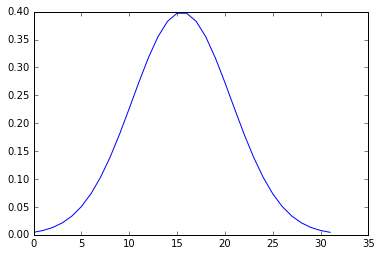

In [11]:
# %% Now a tf.Operation
# We'll use our values from [-3, 3] to create a Gaussian Distribution
sigma = 1.0
mean = 0.0
z = (tf.exp(tf.negative(tf.pow(x - mean, 2.0) /
                   (2.0 * tf.pow(sigma, 2.0)))) *
     (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))

# %% By default, new operations are added to the default Graph
assert z.graph is tf.get_default_graph()

# %% Execute the graph and plot the result
plt.plot(z.eval())

(32,)
[32]
[32]
[[32]
 [32]
 [ 3]
 [ 4]]


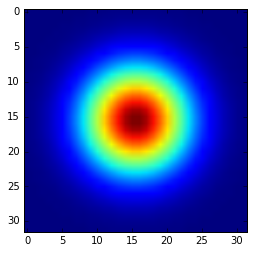

In [12]:
# %% We can find out the shape of a tensor like so:
print(z.get_shape())

# %% Or in a more friendly format
print(z.get_shape().as_list())

# %% Sometimes we may not know the shape of a tensor
# until it is computed in the graph.  In that case
# we should use the tf.shape fn, which will return a
# Tensor which can be eval'ed, rather than a discrete
# value of tf.Dimension
print(tf.shape(z).eval())

# %% We can combine tensors like so:
print(tf.stack([tf.shape(z), tf.shape(z), [3], [4]]).eval())

# %% Let's multiply the two to get a 2d gaussian
z_2d = tf.matmul(tf.reshape(z, [n_values, 1]), tf.reshape(z, [1, n_values]))

# %% Execute the graph and store the value that `out` represents in `result`.
plt.imshow(z_2d.eval())


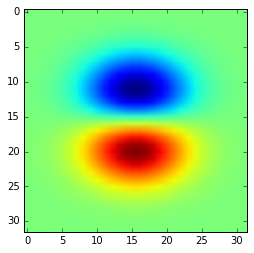

In [13]:
# %% For fun let's create a gabor patch:
x = tf.reshape(tf.sin(tf.linspace(-3.0, 3.0, n_values)), [n_values, 1])
y = tf.reshape(tf.ones_like(x), [1, n_values])
z = tf.multiply(tf.matmul(x, y), z_2d)
plt.imshow(z.eval())

In [14]:
# %% We can also list all the operations of a graph:
ops = tf.get_default_graph().get_operations()
print([op.name for op in ops])

[u'LinSpace/start', u'LinSpace/stop', u'LinSpace/num', u'LinSpace', u'LinSpace_1/start', u'LinSpace_1/stop', u'LinSpace_1/num', u'LinSpace_1', u'LinSpace_2/start', u'LinSpace_2/stop', u'LinSpace_2/num', u'LinSpace_2', u'LinSpace_3/start', u'LinSpace_3/stop', u'LinSpace_3/num', u'LinSpace_3', u'LinSpace_4/start', u'LinSpace_4/stop', u'LinSpace_4/num', u'LinSpace_4', u'LinSpace_5/start', u'LinSpace_5/stop', u'LinSpace_5/num', u'LinSpace_5', u'LinSpace_6/start', u'LinSpace_6/stop', u'LinSpace_6/num', u'LinSpace_6', u'LinSpace_7/start', u'LinSpace_7/stop', u'LinSpace_7/num', u'LinSpace_7', u'LinSpace_8/start', u'LinSpace_8/stop', u'LinSpace_8/num', u'LinSpace_8', u'LinSpace_9/start', u'LinSpace_9/stop', u'LinSpace_9/num', u'LinSpace_9', u'sub/y', u'sub', u'Pow/y', u'Pow', u'Pow_1/x', u'Pow_1/y', u'Pow_1', u'mul/x', u'mul', u'div', u'Neg', u'Exp', u'Sqrt/x', u'Sqrt', u'mul_1/x', u'mul_1', u'div_1/x', u'div_1', u'mul_2', u'Shape', u'Shape_1', u'Shape_2', u'stack/2_1', u'stack/3_1', u'stack',

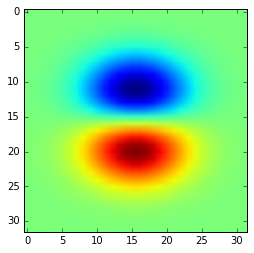

In [15]:
# %% Lets try creating a generic function for computing the same thing:
def gabor(n_values=32, sigma=1.0, mean=0.0):
    x = tf.linspace(-3.0, 3.0, n_values)
    z = (tf.exp(tf.negative(tf.pow(x - mean, 2.0) /
                       (2.0 * tf.pow(sigma, 2.0)))) *
         (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))
    gauss_kernel = tf.matmul(
        tf.reshape(z, [n_values, 1]), tf.reshape(z, [1, n_values]))
    x = tf.reshape(tf.sin(tf.linspace(-3.0, 3.0, n_values)), [n_values, 1])
    y = tf.reshape(tf.ones_like(x), [1, n_values])
    gabor_kernel = tf.multiply(tf.matmul(x, y), gauss_kernel)
    return gabor_kernel

# %% Confirm this does something:
plt.imshow(gabor().eval())

(512, 512, 3)


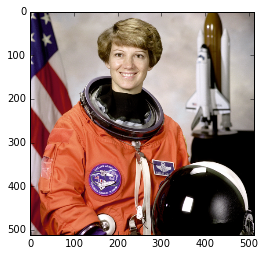

In [16]:
# %% And another function which can convolve
def convolve(img, W):
    # The W matrix is only 2D
    # But conv2d will need a tensor which is 4d:
    # height x width x n_input x n_output
    if len(W.get_shape()) == 2:
        dims = W.get_shape().as_list() + [1, 1]
        W = tf.reshape(W, dims)

    if len(img.get_shape()) == 2:
        # num x height x width x channels
        dims = [1] + img.get_shape().as_list() + [1]
        img = tf.reshape(img, dims)
    elif len(img.get_shape()) == 3:
        dims = [1] + img.get_shape().as_list()
        img = tf.reshape(img, dims)
        # if the image is 3 channels, then our convolution
        # kernel needs to be repeated for each input channel
        W = tf.concat(axis=2, values=[W, W, W])

    # Stride is how many values to skip for the dimensions of
    # num, height, width, channels
    convolved = tf.nn.conv2d(img, W,
                             strides=[1, 1, 1, 1], padding='SAME')
    return convolved

# %% Load up an image:
from skimage import data
img = data.astronaut()
plt.imshow(img)
print(img.shape)

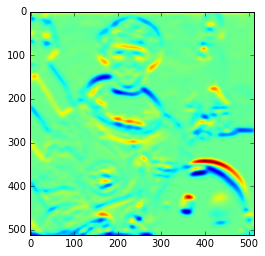

In [17]:
# %% Now create a placeholder for our graph which can store any input:
x = tf.placeholder(tf.float32, shape=img.shape)

# %% And a graph which can convolve our image with a gabor
out = convolve(x, gabor())

# %% Now send the image into the graph and compute the result
result = tf.squeeze(out).eval(feed_dict={x: img})
plt.imshow(result)